In [31]:
import os

subj = "Subj1"
exp = "exp_pca"
print_obj = 7
os.makedirs(f"{subj}/{exp}", exist_ok = True)

### Imports

In [32]:
%load_ext autoreload
%autoreload 2

import mne
import scipy
import numpy
import pandas
import scipy.stats
import gtda.curves
import gtda.plotting
import gtda.homology
import gtda.diagrams
import gtda.time_series
import sklearn.decomposition

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Epochs

Reading d:\HSE\year-3\HSE\CourseProject\Subj1\src\epochs_filt_rr-epo.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
1046 matching events found
No baseline correction applied
0 projection items activated
No projector specified for this dataset. Please consider the method self.add_proj.


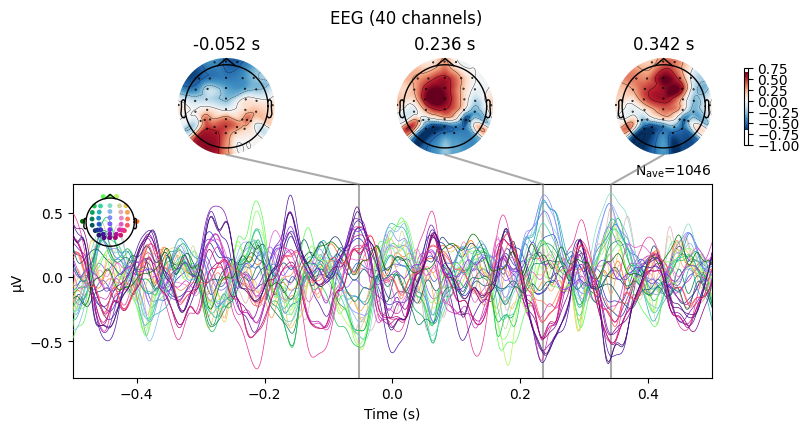

In [33]:
epochs = mne.read_epochs(f"{subj}/src/epochs_filt_rr-epo.fif")
epochs.average().plot_joint().savefig(f"{subj}/{exp}/eeg.svg")

### TakensEmbedding

In [34]:
embedder = gtda.time_series.TakensEmbedding(dimension = 10)
points = embedder.fit_transform(epochs.get_data(copy = True))
print(points.shape)

(1046, 492, 400)


In [35]:
plot = gtda.plotting.plot_point_cloud(points[print_obj])
display(plot)
plot.write_image(file = f"{subj}/{exp}/point_cloud.svg", format = "svg")

### VietorisRipsPersistence

In [40]:
persistence = gtda.homology.WeightedRipsPersistence(homology_dimensions = [0, 1], n_jobs = -1)
raw_diagram = persistence.fit_transform(points)
print(raw_diagram.shape)

(1046, 711, 3)


In [42]:
plot = gtda.plotting.plot_diagram(raw_diagram[8])
display(plot)
plot.write_image(file = f"{subj}/{exp}/raw_diagram.svg", format = "svg")

### Scaler & Filtering

In [43]:
scaler = gtda.diagrams.Scaler()
filtering = gtda.diagrams.Filtering()
diagram = filtering.fit_transform(scaler.fit_transform(raw_diagram))
print(diagram.shape)

(1046, 629, 3)


In [44]:
plot = gtda.plotting.plot_diagram(diagram[print_obj])
display(plot)
plot.write_image(file = f"{subj}/{exp}/diagram.svg", format = "svg")

### Features

In [45]:
landscape_features = gtda.diagrams.PersistenceLandscape().fit_transform(diagram)
landscape_features = gtda.curves.StandardFeatures('argmax').fit_transform(landscape_features)
print(landscape_features.shape)

(1046, 2)


In [46]:
betti_features = gtda.diagrams.BettiCurve().fit_transform(diagram)
betti_features = gtda.curves.Derivative().fit_transform(betti_features)
betti_features = gtda.curves.StandardFeatures('max').fit_transform(betti_features)
print(betti_features.shape)

(1046, 2)


In [47]:
entropy_features = gtda.diagrams.PersistenceEntropy().fit_transform(diagram)
print(entropy_features.shape)

(1046, 2)


In [48]:
number_of_points_features = gtda.diagrams.NumberOfPoints().fit_transform(diagram)
print(number_of_points_features.shape)

(1046, 2)


In [49]:
amplitude_features = [ ]
for metric in [ 'bottleneck', 'wasserstein', 'betti', 'landscape', 'silhouette', 'heat' ]:
    amplitude_features.append(gtda.diagrams.Amplitude(metric = metric).fit_transform(diagram))
amplitude_features = numpy.concatenate(amplitude_features, axis = 1)
print(amplitude_features.shape)

(1046, 12)


In [50]:
pd_ft_life = diagram[:, :, 1] - diagram[:, :, 0]
life_features = numpy.stack([
    numpy.max(pd_ft_life, axis = 1),
    numpy.mean(pd_ft_life, axis = 1),
    numpy.std(pd_ft_life, axis = 1),
    numpy.percentile(pd_ft_life, 25, axis = 1),
    numpy.median(pd_ft_life, axis = 1),
    numpy.percentile(pd_ft_life, 75, axis = 1),
    scipy.stats.kurtosis(pd_ft_life, axis = 1),
    scipy.stats.skew(pd_ft_life, axis = 1),
    numpy.sum(pd_ft_life, axis = 1),
    numpy.linalg.norm(pd_ft_life, axis = 1)
], axis = 1)
print(life_features.shape)

(1046, 10)


In [51]:
pd_ft_bd2 = (diagram[:, :, 0] + diagram[:, :, 1]) / 2.0
bd2_features = numpy.stack([
    numpy.max(pd_ft_bd2, axis = 1),
    numpy.mean(pd_ft_bd2, axis = 1),
    numpy.std(pd_ft_bd2, axis = 1),
    numpy.percentile(pd_ft_bd2, 25, axis = 1),
    numpy.median(pd_ft_bd2, axis = 1),
    numpy.percentile(pd_ft_bd2, 75, axis = 1),
    scipy.stats.kurtosis(pd_ft_bd2, axis = 1),
    scipy.stats.skew(pd_ft_bd2, axis = 1),
    numpy.sum(pd_ft_bd2, axis = 1),
    numpy.linalg.norm(pd_ft_bd2, axis = 1)
], axis = 1)
print(bd2_features.shape)

(1046, 10)


In [52]:
features = numpy.concatenate([
    landscape_features,
    betti_features,
    entropy_features,
    number_of_points_features,
    amplitude_features,
    life_features,
    bd2_features
], axis = 1)
print(features.shape)

(1046, 40)


### Save

In [53]:
N_COMP = 0.999
pca = sklearn.decomposition.PCA(n_components = N_COMP, random_state = 0)
pca_features = pca.fit_transform(features)

print(pca_features.shape)
print('Explained variance', round(pca.explained_variance_ratio_.sum(), 2))
print([ round(x, 3) for x in pca.explained_variance_ratio_ ])

(1046, 8)
Explained variance 1.0
[0.794, 0.176, 0.019, 0.004, 0.003, 0.002, 0.001, 0.0]


In [54]:
df = pandas.DataFrame(pca_features)
df.to_feather(f"{subj}/{exp}/features.feather")
df

,0,1,2,3,4,5,6,7
0,240.713051,149.713402,-6.106648,3.640468,-2.258585,4.475970,-2.151831,-0.526553
1,278.337596,89.468121,2.271386,2.802293,4.484252,8.675473,-1.204237,2.405972
2,181.548712,161.370111,-33.923084,11.634576,-5.970482,24.230486,2.199355,2.632871
3,277.716479,25.950566,23.814649,-7.551931,1.401574,10.226155,5.900928,-3.950157
4,326.040572,102.594271,-16.843275,10.679664,0.449878,-0.604795,-2.507459,0.495124
...,...,...,...,...,...,...,...,...
1041,21.634200,-27.457028,29.172026,8.084509,-0.679164,5.271957,6.641633,2.792913
1042,31.782398,-26.547816,45.611107,7.392933,-11.180408,6.359391,-24.321636,-13.149705
1043,-28.117314,-17.458953,18.628805,-2.943328,-6.177529,-1.894994,0.248944,-0.803142
1044,-149.188642,43.276501,16.808537,-3.140569,4.632210,-0.040774,0.888652,-1.803987
